In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.ticker import FuncFormatter
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1
SCHEME_STEPS = int(1e4)
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

## Diffusion equation

* $dX_t = \sigma_tC(X_t)dW_t$

* $d\sigma_t = \eta \sigma_tdB_t$

* $d<W,B>_t = \rho dt$

* $C(x) = \frac{\frac{\beta}{\alpha}(\frac{x}{\alpha})^{\beta-1}}{(1+(\frac{x}{\alpha}^\beta))^2}$
* $mode = \alpha (\frac{\beta-1}{\beta+1})^{\frac{1}{\beta}}$


## Local vol shape

This local vol form vanishes at 0 and for large strikes, reaches its maximum at strike $K_{max}$ and the spatial extension around $K_{max}$ is controlled by $c$ :

$
\sigma_{loc}(x) = \frac{\frac{\beta}{\alpha}(\frac{x}{\alpha})^{\beta-1}}{(1+(\frac{x}{\alpha}^\beta))^2}
$

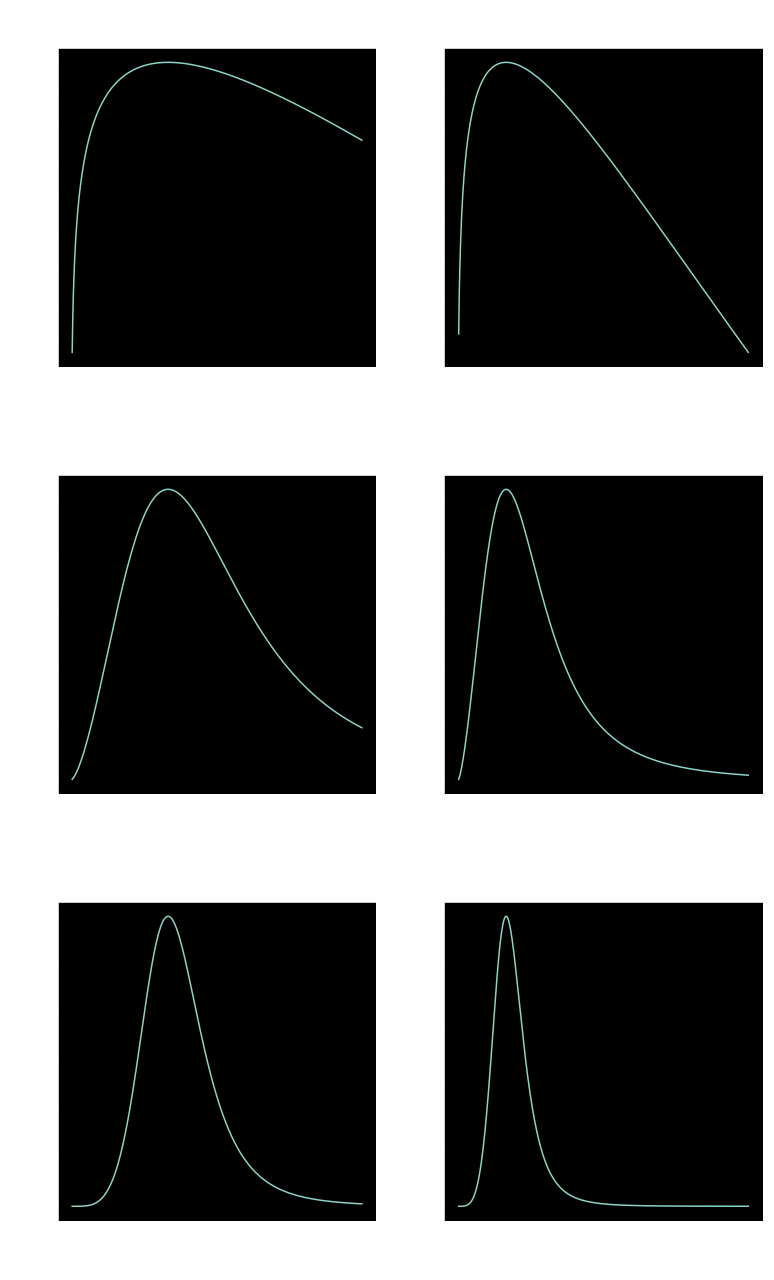

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2)

xs = np.linspace(1*ONE_BP, 3*ONE_PCT, N_STRIKES)

def local_vol_gen(mode, beta, x):
    alpha = mode * ((beta+1)/(beta-1))**(1/beta)
    return beta/alpha*(x/alpha)**(beta-1)/(1+(x/alpha)**beta)**2

params = [
    [1*ONE_PCT, 1.05],
    [1*ONE_PCT, 2.5],
    [1*ONE_PCT, 5.0],
    [50*ONE_BP, 1.05],
    [50*ONE_BP, 2.5],
    [50*ONE_BP, 5.0],
]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        mode = params[i+3*j][0]
        beta = params[i+3*j][1]
        
        local_vol = partial(local_vol_gen, mode, beta)
        
        ax.plot(xs, local_vol(xs))
        ax.set_xlabel('strike\n')
        ax.set_ylabel('local vol')
        ax.set_title(r'mode={:.2%}'.format(mode)+'\n'\
                     r'beta={:.2f}'.format(beta)
                    )
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.tight_layout()
plt.show()

## Numerical experiments

In [5]:
f = 1*ONE_PCT
mode = 20*ONE_BP
beta = 1.9
vov = 40*ONE_PCT
rho = -40*ONE_PCT
K_lo = 20*ONE_BP
K_hi = 2*ONE_PCT
sigma_0 = 100*ONE_BP

In [6]:
Model_LN = SABR_AS_loglogistic_LN(mode=mode, 
                                  beta=beta, 
                                  vov=vov,
                                  rho=rho,
                                  f=f,
                                  sigma_0=sigma_0,
                                  n_strikes=N_STRIKES,
                                  K_lo=K_lo,
                                  K_hi=K_hi,
                                  strike_type='strike'
                                 )
Model_N = SABR_AS_loglogistic_N(mode=mode,
                                beta=beta,
                                vov=vov,
                                rho=rho,
                                f=f,
                                sigma_0=sigma_0,
                                n_strikes=N_STRIKES,
                                K_lo=K_lo, 
                                K_hi=K_hi, 
                                strike_type='strike'
                               )

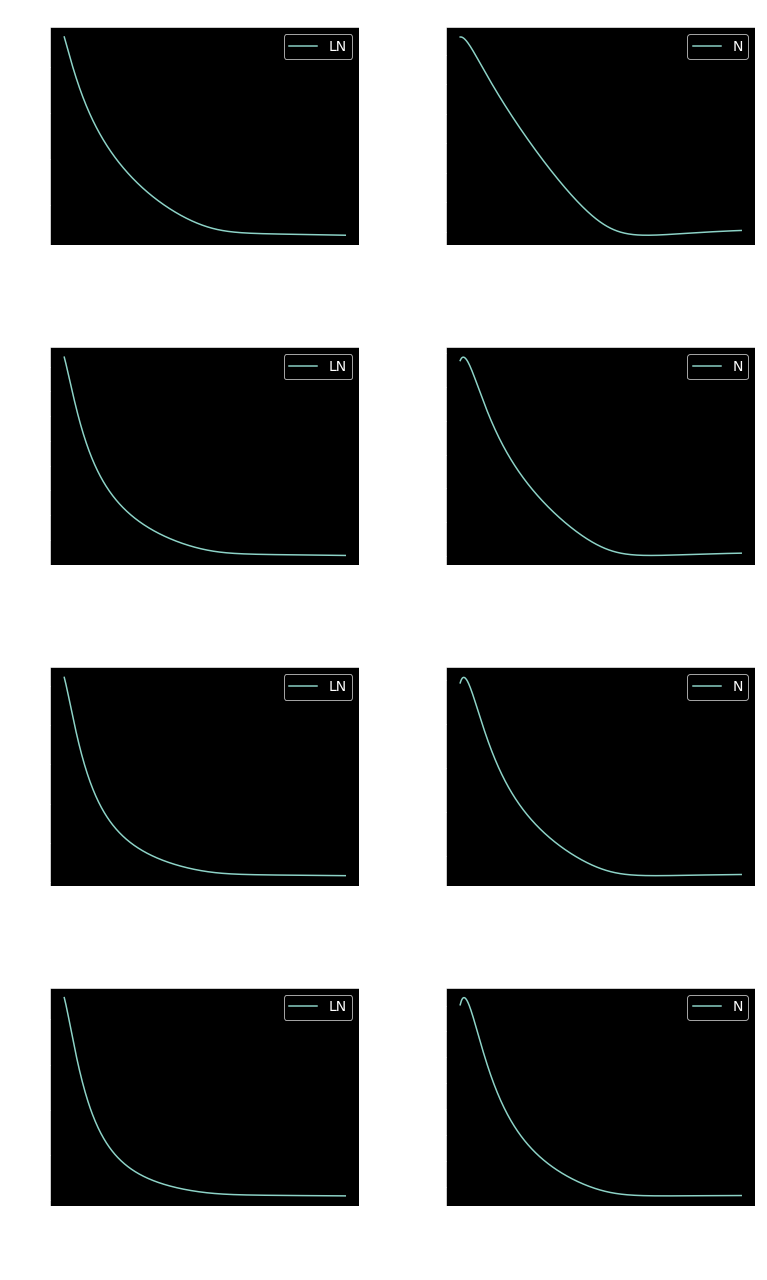

In [7]:
#xlabel = 'logmoneyness\n\n'
xlabel = 'strike\n\n'
ylabel = 'implied vol'
labels = ['LN', 'N']

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax_row in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    #x_grid = Model_LN.logmoneyness_grid
    x_grid = Model_LN.strike_grid

    models = [Model_LN, Model_N]
    for j, ax in enumerate(ax_row):
        model = models[j]
        label = labels[j]
        smile = list(model.smile.values())

        ax.plot(x_grid, smile, label=label)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.set_title('expiry={}y'.format(T_expiry))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
plt.tight_layout()
plt.show()

## Implied probability density

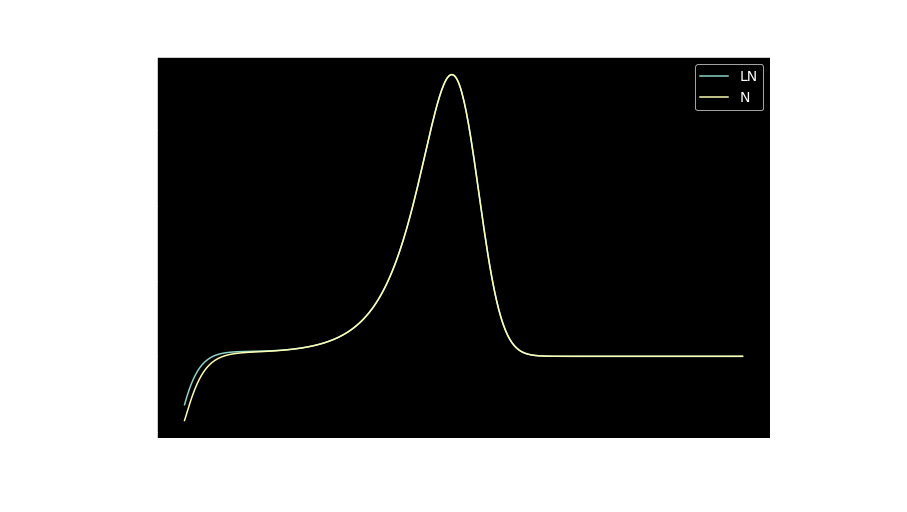

In [8]:
#xlabel = 'logmoneyness\n\n'
xlabel = 'strike\n\n'
ylabel = 'pdf'

T_expiry = 1.0

fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

plt.suptitle(r'$f$={:.2%}'.format(Model_LN.f)+', '+\
             r'beta={:.2f}'.format(Model_LN.beta)+', '+\
             r'mode={:.2%}'.format(Model_LN.mode)+', '+\
             r'vov={:.0%}'.format(Model_LN.vov)+', '+\
             r'$\rho$={:.0%}'.format(Model_LN.rho)+', '+\
             r'ATM(LN)={:.2%}, ATM(N)={:.2f}bps'.format(Model_LN.ATM, Model_N.ATM/ONE_BP)+', '+\
             r'$\sigma_0$={:.2%}'.format(Model_LN.sigma_0)
            )

Model_LN.T_expiry = T_expiry
Model_N.T_expiry = T_expiry

#x_grid = Model_LN.logmoneyness_grid
x_grid = Model_LN.strike_grid

pdf_LN = list(Model_LN.pdf_curve.values())
pdf_N = list(Model_N.pdf_curve.values())

ax.plot(x_grid, pdf_LN, label='LN')
ax.plot(x_grid, pdf_N, label='N')

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(loc='upper right')

ax.set_title(r'expiry={}y'.format(T_expiry))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.subplots_adjust(hspace=0.4)
plt.show()

## Backbone i.e ATM vol move implied by forward move

The idea behind this local vol form is to ensure increasing vol for decreasing forward, an observed behaviour in rates markets when forwards are near a perceived rates floor.

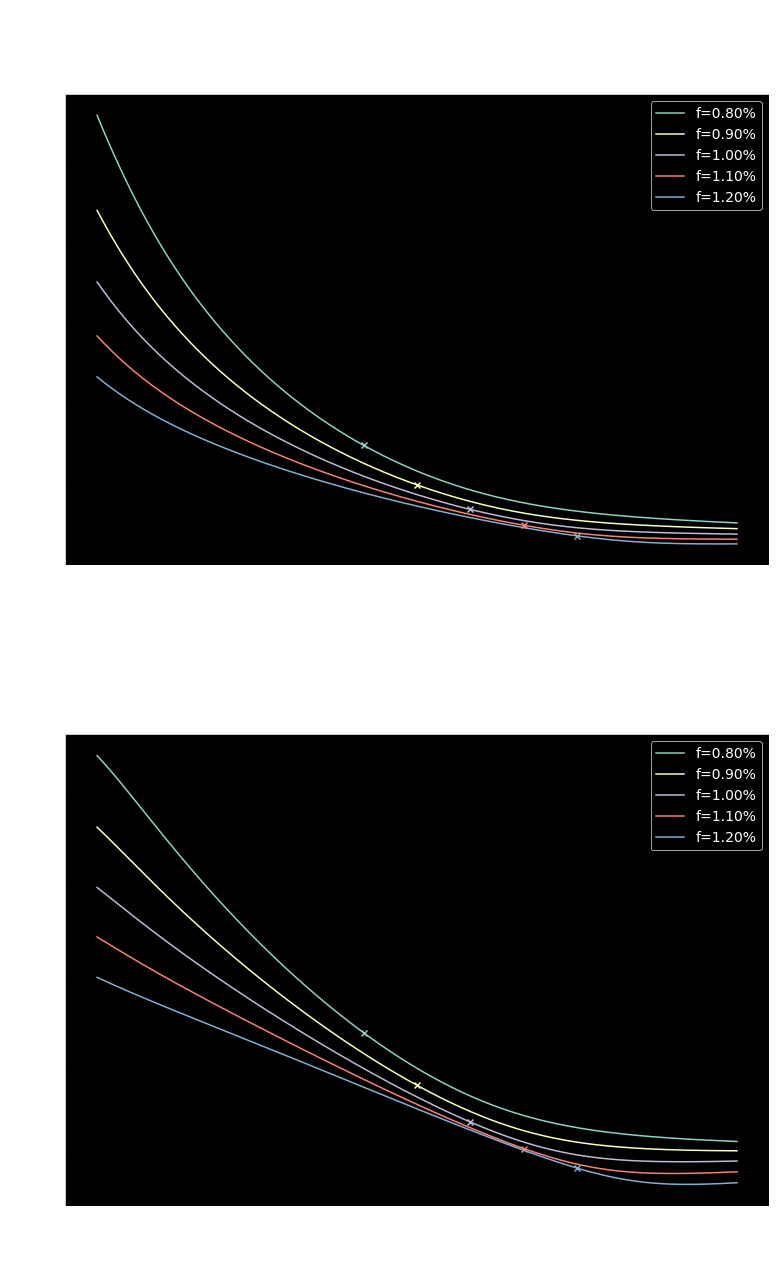

In [9]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 1*ONE_PCT

f_shocks = [
    -20*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    20*ONE_BP
]

vov = 40*ONE_PCT
rho = -40*ONE_PCT

mode = 20*ONE_BP
beta = 1.9
sigma_0 = 100*ONE_BP

K_lo = 30*ONE_BP
K_hi = 150*ONE_BP

Model_LN = SABR_AS_loglogistic_LN(mode=mode, 
                                  beta=beta, 
                                  vov=vov,
                                  rho=rho,
                                  f=f,
                                  sigma_0=sigma_0,
                                  n_strikes=N_STRIKES,
                                  T_expiry=1.0,
                                  K_lo=K_lo, 
                                  K_hi=K_hi,
                                  strike_type='strike'
                             )
Model_N = SABR_AS_loglogistic_N(mode=mode,
                                beta=beta,
                                vov=vov,
                                rho=rho,
                                f=f,
                                sigma_0=sigma_0,
                                n_strikes=N_STRIKES,
                                T_expiry=1.0,
                                K_lo=K_lo, 
                                K_hi=K_hi, 
                                strike_type='strike'
                               )

models = [Model_LN, Model_N]

fig, axes = plt.subplots(nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = list(model.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)\
                     +'mode={:.2%}'.format(mode) +'\n'
                     +r'$\beta$={:.2f}'.format(beta) +'\n')

plt.tight_layout()
plt.show()

## Parameter sensitivities

Vol of vol controls the convexity of the smile, $\rho$ the skew (i.e rotation around the ATM).
Both have little to no effect on the ATM itself.

$\sigma_0$ controls the ATM via parallel shifts of the whole smile.

$mode$ and $\beta$ control the backbone shape; their effect on the instantaneous smile can be absorbed by $\sigma_0$.

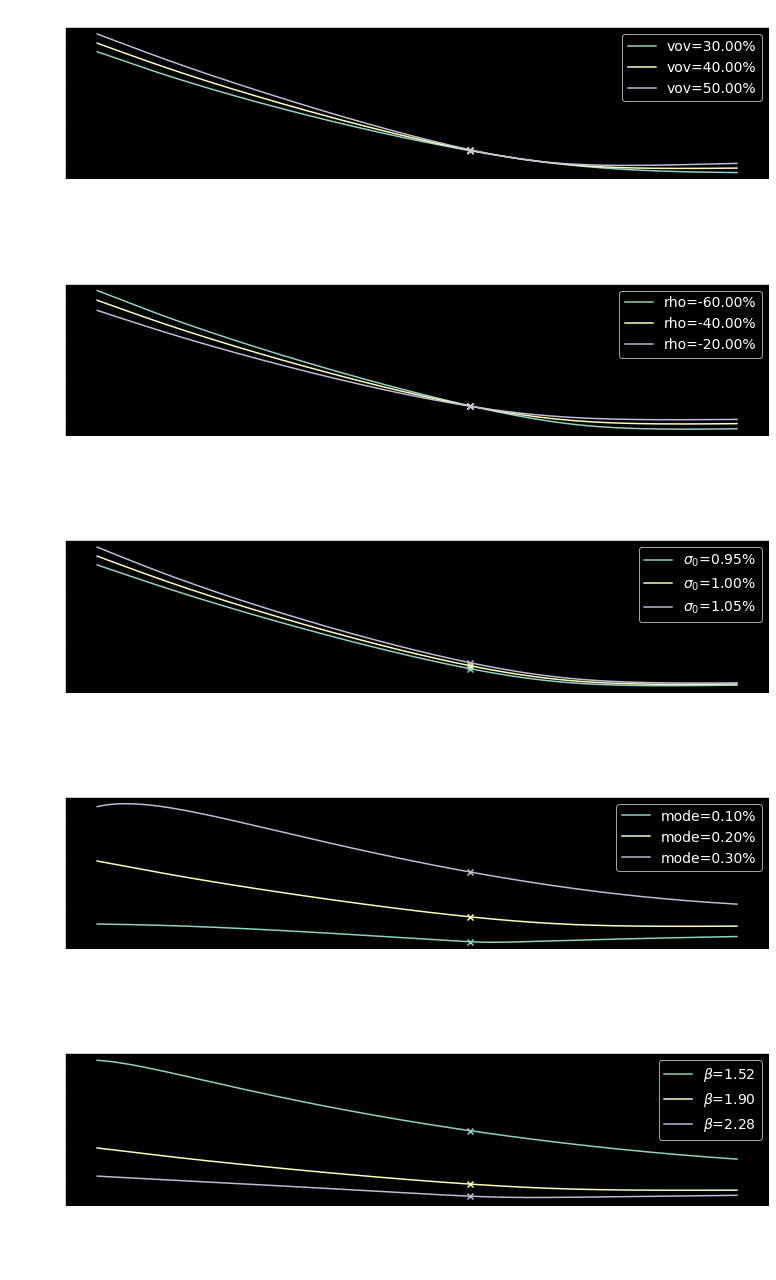

In [10]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 1*ONE_PCT

vov_shocks = [-10*ONE_PCT, 0.0, 10*ONE_PCT]
rho_shocks = [-20*ONE_PCT, 0.0, 20*ONE_PCT]
sigma_0_shocks = [-5*ONE_BP, 0.0, 5*ONE_BP]
mode_shocks = [-10*ONE_BP, 0.0, 10*ONE_BP]
beta_shocks = [0.8, 1, 1.2]

vov = 40*ONE_PCT
rho = -40*ONE_PCT

mode = 20*ONE_BP
beta = 1.9
sigma_0 = 100*ONE_BP

K_lo = 30*ONE_BP
K_hi = 150*ONE_BP

fig, axes = plt.subplots(nrows=5, ncols=1)

ax = axes[0]  
model = SABR_AS_loglogistic_N(mode=mode,
                              beta=beta,
                              vov=vov,
                              rho=rho,
                              f=f,
                              sigma_0=sigma_0,
                              n_strikes=N_STRIKES,
                              T_expiry=1.0,
                              K_lo=K_lo, 
                              K_hi=K_hi, 
                              strike_type='strike'
                             )

for vov_shock in vov_shocks:
    model.vov = vov+vov_shock
    
    smile = list(model.smile.values())
    label = 'vov={:.2%}'.format(vov+vov_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Vol of vol shock')

ax = axes[1]
model = SABR_AS_loglogistic_N(mode=mode,
                              beta=beta,
                              vov=vov,
                              rho=rho,
                              f=f,
                              sigma_0=sigma_0,
                              n_strikes=N_STRIKES,
                              T_expiry=1.0,
                              K_lo=K_lo, 
                              K_hi=K_hi, 
                              strike_type='strike'
                             )

for rho_shock in rho_shocks:
    model.rho = rho+rho_shock
    
    smile = list(model.smile.values())
    label = 'rho={:.2%}'.format(rho+rho_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Correlation shock')
    
ax = axes[2]
model = SABR_AS_loglogistic_N(mode=mode,
                              beta=beta,
                              vov=vov,
                              rho=rho,
                              f=f,
                              sigma_0=sigma_0,
                              n_strikes=N_STRIKES,
                              T_expiry=1.0,
                              K_lo=K_lo, 
                              K_hi=K_hi, 
                              strike_type='strike'
                             )
for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock

    smile = list(model.smile.values())
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Initial vol shock')

ax = axes[3]
model = SABR_AS_loglogistic_N(mode=mode,
                              beta=beta,
                              vov=vov,
                              rho=rho,
                              f=f,
                              sigma_0=sigma_0,
                              n_strikes=N_STRIKES,
                              T_expiry=1.0,
                              K_lo=K_lo, 
                              K_hi=K_hi, 
                              strike_type='strike'
                             )

for mode_shock in mode_shocks:
    model.mode = mode + mode_shock
    smile = list(model.smile.values())
    label = r'mode={:.2%}'.format(model.mode)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'mode shock')

ax = axes[4]
model = SABR_AS_loglogistic_N(mode=mode,
                              beta=beta,
                              vov=vov,
                              rho=rho,
                              f=f,
                              sigma_0=sigma_0,
                              n_strikes=N_STRIKES,
                              T_expiry=1.0,
                              K_lo=K_lo, 
                              K_hi=K_hi, 
                              strike_type='strike'
                             )

for beta_shock in beta_shocks:
    model.beta = beta*beta_shock
    smile = list(model.smile.values())
    label = r'$\beta$={:.2f}'.format(model.beta)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'$\beta$ shock')

plt.tight_layout()
plt.show()